In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.preprocessing import RobustScaler 
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor




In [2]:
#define wrangle function
def wrangle(dataset):
    #read csv
    df = pd.read_csv(dataset)
    #cols to drop
    cols_to_drop = ['PoolQC','Alley','MiscFeature','Fence', 'FireplaceQu','MasVnrType', 'Id']

    #handle categorical missingness
    categ_vars = df.select_dtypes('object').columns
    for cat_col in categ_vars:
        df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])
    
    #handle numerical missingness
    num_cols = df.select_dtypes(['int','float']).columns
    for num in num_cols:
        df[num] = df[num].fillna(df[num].mean())
    #drop multicollinearity
    collinear = ['BedroomAbvGr', 'GarageYrBlt', '2ndFlrSF', '1stFlrSF', 'GarageCars', 'GrLivArea']
    #append
    cols_to_drop.extend(collinear)

    #handle outliers
    Q1 = df['SalePrice'].quantile(0.25)
    Q3 = df['SalePrice'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the entire DataFrame based on SalePrice bounds
    df = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]
    

    #drop cols
    df.drop(columns = cols_to_drop, inplace=True)

    return df

In [3]:
df = wrangle('train.csv')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1399 entries, 0 to 1459
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1399 non-null   int64  
 1   MSZoning       1399 non-null   object 
 2   LotFrontage    1399 non-null   float64
 3   LotArea        1399 non-null   int64  
 4   Street         1399 non-null   object 
 5   LotShape       1399 non-null   object 
 6   LandContour    1399 non-null   object 
 7   Utilities      1399 non-null   object 
 8   LotConfig      1399 non-null   object 
 9   LandSlope      1399 non-null   object 
 10  Neighborhood   1399 non-null   object 
 11  Condition1     1399 non-null   object 
 12  Condition2     1399 non-null   object 
 13  BldgType       1399 non-null   object 
 14  HouseStyle     1399 non-null   object 
 15  OverallQual    1399 non-null   int64  
 16  OverallCond    1399 non-null   int64  
 17  YearBuilt      1399 non-null   int64  
 18  YearRemodAdd 

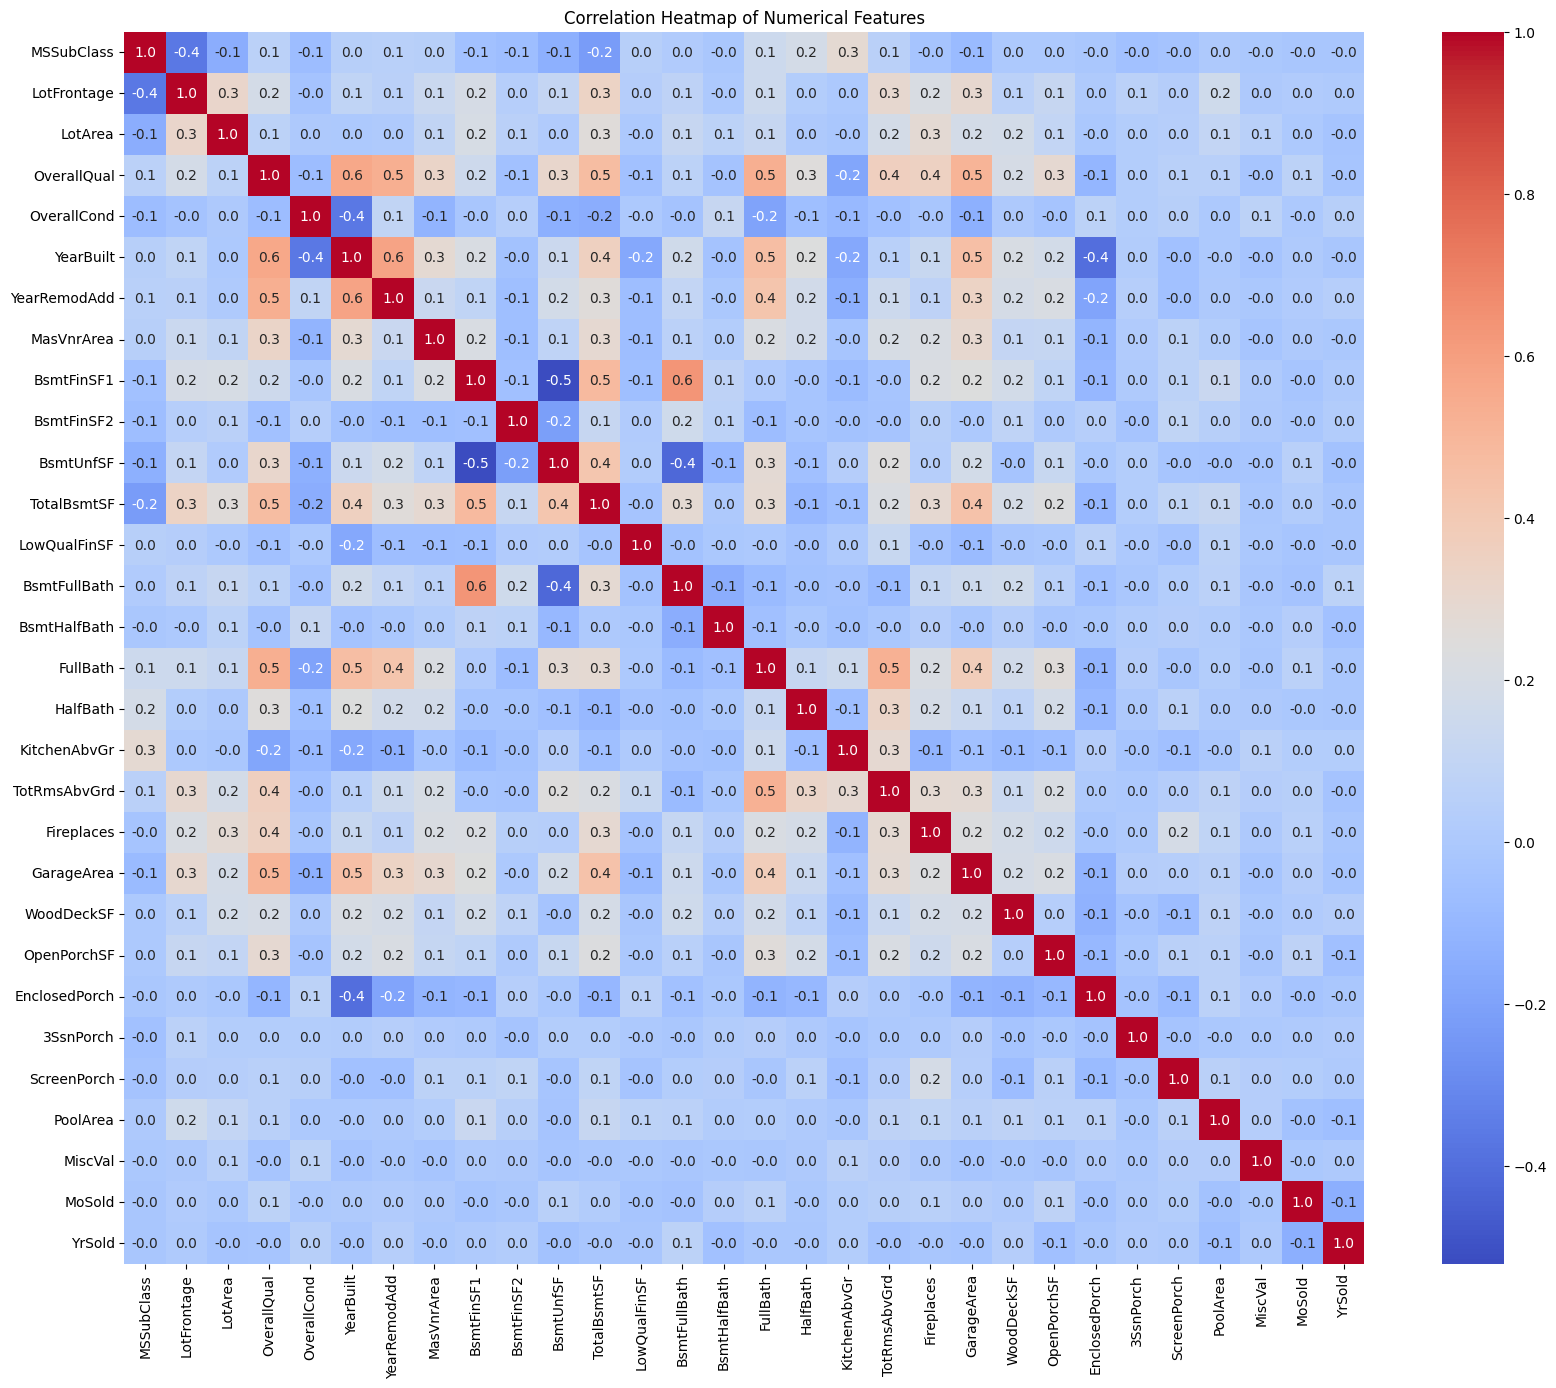

In [5]:
#check correlation for numerical features
num_feat = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(num_feat, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [6]:
#num cols
num_feats = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).columns
num_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

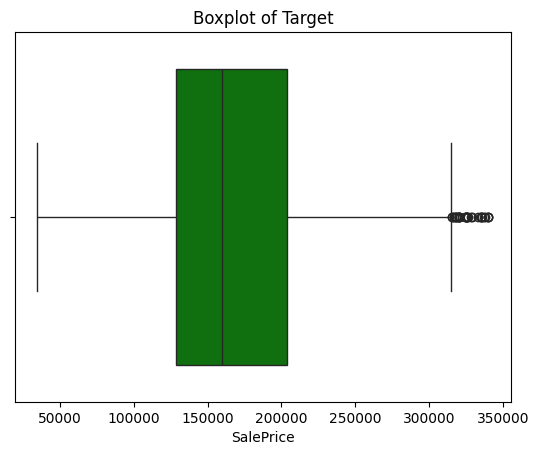

In [7]:
#target
sale = df['SalePrice']
#sale.plot(kind='box')
sns.boxplot(sale, orient='h', color='g')
plt.title('Boxplot of Target');


In [8]:
categorical_feat = df.select_dtypes('object')#.columns
#df[categorical_feat].head()
print('shape:', categorical_feat.shape)

shape: (1399, 37)


In [9]:
#get dummies
dummies = pd.get_dummies(categorical_feat, drop_first=True).astype(int)

print('shape of dummies:', dummies.shape)
print('shape of df', df.shape)

shape of dummies: (1399, 193)
shape of df (1399, 68)


In [10]:
dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [11]:
#numerical shape
numerical_feat = df.select_dtypes(['float', 'int'])
print('Shape of numerical df:', numerical_feat.shape)

Shape of numerical df: (1399, 31)


In [12]:
#join dfs
df_conc = pd.concat([dummies, numerical_feat], axis=1)
df_conc.shape

(1399, 224)

In [13]:
#target
target = 'SalePrice'
X = df_conc.drop(target, axis=1)
y = df_conc[np.log1p(target)]

In [14]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [15]:
print('Size of X_train:', X_train.shape)
print('Size of X_test:', X_test.shape)
print('Size of y train:', y_train.shape)
print('Size of y test:', y_test.shape)

Size of X_train: (1119, 223)
Size of X_test: (280, 223)
Size of y train: (1119,)
Size of y test: (280,)


In [16]:
print(y_train.mean())

171335.21894548705


In [17]:
# y_train mean
y_train_mean = y_train.mean()
#rmse_baseline
y_pred_baseline  = len(y_train)*[y_train_mean]
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_baseline))

In [18]:
#instantiate model
model = LinearRegression()

#fit model to data
model.fit(X_train, np.log1p(y_train))

#predict on training data
y_pred_training = model.predict(X_train)
#print(y_pred_training.min())
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_training))

#predict on test data
y_pred_test = model.predict(X_test)
#print(y_pred_test.min())
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


#print mae_baseline
print('Baseline RMSE:', rmse_baseline)
#print training
print('RMSE_training_Linear:', rmse_train)
#print mae_testing
print('RMSE_testing_Linear:', rmse_test)

Baseline RMSE: 59841.20187067935
RMSE_training_Linear: 181473.3573272632
RMSE_testing_Linear: 175164.51106329603


In [19]:
#tune random forest tree
def objective(trial):
    #hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0)
    }
    #instantiate model
    model = RandomForestRegressor(**params, random_state=42)
    #split
    kf = KFold(n_splits= 5, shuffle=True, random_state =42)
    #score
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)

    return -np.mean(scores)
#create study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)

#print best parameters
print('n estimators:', study.best_params['n_estimators'])
print('max depth:', study.best_params['max_depth'])
print('max features:', study.best_params['max_features'])





[I 2025-07-29 11:08:38,727] A new study created in memory with name: no-name-27d1ed16-d960-4478-81f6-1c7061414bc3


[I 2025-07-29 11:08:49,590] Trial 0 finished with value: 23404.39142101906 and parameters: {'n_estimators': 81, 'max_depth': 10, 'max_features': 0.7319939418114051}. Best is trial 0 with value: 23404.39142101906.
[I 2025-07-29 11:08:54,594] Trial 1 finished with value: 29079.98747319439 and parameters: {'n_estimators': 124, 'max_depth': 4, 'max_features': 0.15599452033620265}. Best is trial 0 with value: 23404.39142101906.
[I 2025-07-29 11:08:57,796] Trial 2 finished with value: 24087.399458249878 and parameters: {'n_estimators': 21, 'max_depth': 9, 'max_features': 0.6011150117432088}. Best is trial 0 with value: 23404.39142101906.
[I 2025-07-29 11:09:07,708] Trial 3 finished with value: 31281.353002490574 and parameters: {'n_estimators': 145, 'max_depth': 3, 'max_features': 0.9699098521619943}. Best is trial 0 with value: 23404.39142101906.
[I 2025-07-29 11:09:13,956] Trial 4 finished with value: 28822.411309896608 and parameters: {'n_estimators': 168, 'max_depth': 4, 'max_features': 

n estimators: 168
max depth: 10
max features: 0.5139465011097675


In [20]:
#instantiate model
rf_model = RandomForestRegressor(n_estimators = 168, max_depth=10, max_features=0.5139465011097675, random_state=42)

#train model
rf_model.fit(X_train, y_train)

#predict on training
y_pred_train = rf_model.predict(X_train)

#error on training
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#predict on test set
y_pred_test = rf_model.predict(X_test)

#test error
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))



RMSE Training Error: 10124.161202062929
RMSE Testing Error: 21178.159105468392


In [31]:
print('RMSE baseline', rmse_baseline)
print('RMSE Training Error:', rmse_train)
print('RMSE Testing Error:', rmse_test)

RMSE baseline 59841.20187067935
RMSE Training Error: 10124.161202062929
RMSE Testing Error: 21178.159105468392


In [25]:
#Get best parameters for gradient boosting
def objective(trial):
    
    #hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.0, 1.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 50)
    }
    
    #model instantiation
    model_gb = GradientBoostingRegressor(**params, random_state=42)
    
    #splits
    kf_gb = KFold(n_splits=5, shuffle=True, random_state =42)
    
    #get scores
    scores_gb = cross_val_score(model_gb, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=kf_gb)

    return -np.mean(scores_gb)

study_gb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_gb.optimize(objective, n_trials=100)






[I 2025-07-29 11:51:52,597] A new study created in memory with name: no-name-8288bfa1-600d-416a-945c-b93e463f3d0a
[I 2025-07-29 11:52:00,637] Trial 0 finished with value: 30817.08249689305 and parameters: {'n_estimators': 118, 'learning_rate': 0.9507635921035062, 'max_depth': 8, 'max_features': 0.5986584841970366, 'min_samples_split': 0.15601864044243652, 'min_samples_leaf': 9}. Best is trial 0 with value: 30817.08249689305.
[I 2025-07-29 11:52:03,421] Trial 1 finished with value: 29456.249751821637 and parameters: {'n_estimators': 26, 'learning_rate': 0.8663099696291603, 'max_depth': 7, 'max_features': 0.7080725777960455, 'min_samples_split': 0.020584494295802447, 'min_samples_leaf': 49}. Best is trial 1 with value: 29456.249751821637.
[I 2025-07-29 11:52:10,401] Trial 2 finished with value: 21389.641384831433 and parameters: {'n_estimators': 252, 'learning_rate': 0.21312677156759788, 'max_depth': 4, 'max_features': 0.18340450985343382, 'min_samples_split': 0.3042422429595377, 'min_sa

n estimators: 168
max depth: 10
max features: 0.5139465011097675


KeyError: 'min_sample_split'

In [27]:
#print best parameters
print('n estimators:', study_gb.best_params['n_estimators'])
print('max depth:', study_gb.best_params['max_depth'])
print('max features:', study_gb.best_params['max_features'])
print('min_samples_split:', study_gb.best_params['min_samples_split'])
print('learning_rate:', study_gb.best_params['learning_rate'])
print('min_samples_leaf:', study_gb.best_params['min_samples_leaf'])

n estimators: 224
max depth: 9
max features: 0.846860269203542
min_samples_split: 0.5951173133644603
learning_rate: 0.14419879268307606
min_samples_leaf: 10


In [29]:
#instantiate model
gb_model = GradientBoostingRegressor(learning_rate = 0.14419879268307606, min_samples_leaf =10, n_estimators = 224, max_depth=9, max_features=0.846860269203542, min_samples_split=0.5951173133644603, random_state=42)

#train model
gb_model.fit(X_train, y_train)

#predict on training
y_pred_training = gb_model.predict(X_train)

#error on training
gb_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_training))

#predict on test set
y_pred_testing = gb_model.predict(X_test)

#test error
gb_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_testing))



RMSE Training Error: 12686.924681225233
RMSE Testing Error: 18697.20875745367


In [33]:
print('RMSE baseline', rmse_baseline)
print('RMSE Training Error:', rmse_train)
print('RMSE Testing Error:', rmse_test)

print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

print('RMSE baseline', rmse_baseline)
print('RMSE Training Error:', gb_rmse_train)
print('RMSE Testing Error:', gb_rmse_test)

RMSE baseline 59841.20187067935
RMSE Training Error: 10124.161202062929
RMSE Testing Error: 21178.159105468392
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
RMSE baseline 59841.20187067935
RMSE Training Error: 12686.924681225233
RMSE Testing Error: 18697.20875745367
